# LB06: Знакомство за обработкой естественного языка

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, 2021 </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемый к материалу датасет лицензия не распространяется. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/lab_6

Mounted at /content/drive
/content/drive/MyDrive/lab_6


В этой лабораторной работе вы будете знакомиться с NLP на примере задаче по определению "неискренних" вопросов на quora. По этой ссылке можно ознакомиться с задачей и данными https://www.kaggle.com/c/quora-insincere-questions-classification. Самое важное копирую сюда:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

    Has a non-neutral tone
        Has an exaggerated tone to underscore a point about a group of people
        Is rhetorical and meant to imply a statement about a group of people
    Is disparaging or inflammatory
        Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
        Makes disparaging attacks/insults against a specific person or group of people
        Based on an outlandish premise about a group of people
        Disparages against a characteristic that is not fixable and not measurable 
    Isn't grounded in reality
        Based on false information, or contains absurd assumptions
    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

Датасет нужно скачивать со страницы https://www.kaggle.com/c/quora-insincere-questions-classification/data (нужно будет принять правила, как обычно)

In [ ]:
df = pd.read_csv('train.csv')
#df = pd.read_csv('train.csv', skiprows=lambda row: row % 5 > 0)

ВНИМАНИЕ! Если ваш компьютер будет считать слишком долго на полном датасете, то загружайте вторым способом. skiprows=lambda row: row % 5 > 0 означает, что будет прочитана только каждая пятая строка.

Либо используйте kaggle kernels или google colaboratory

# Часть 0. Ваше впечатление от датасета

Сделайте аналитику на ваш выбор. Посмотрите на распределение целевой переменной, почитайте тексты, для которых она равна 1. Сделайте выводы

In [ ]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df.shape

(1306122, 3)

In [ ]:
true_class_weight = df.target.mean()
true_class_weight

0.06187017751787352

Как можно видеть, соотношение классов очень несбалансированное

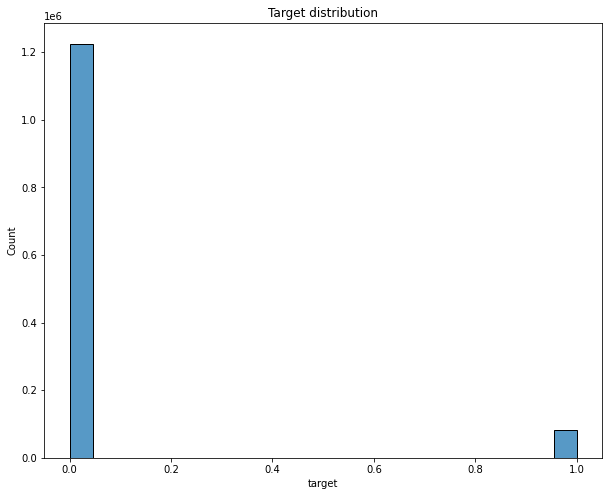

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Target distribution')
sns.histplot(df, x='target')
plt.show()

In [ ]:
questions_seq = df.loc[df.target == 1, 'question_text'].to_numpy()

In [ ]:
questions_seq[:30]

array(['Has the United States become the largest dictatorship in the world?',
       'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
       "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
       'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
       'Which races have the smallest penis?',
       'Why do females find penises ugly?',
       'How do I marry an American woman for a Green Card? How much do they charge?',
       "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
       'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
       "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually r

# Часть 1. Tf-Idf

В этой части необходимо пройти классический путь решения задачи методом "мешок слов". Ваша задача:
1. Нормализовать данные (если нужно)
2. Выбрать вариант токенизации (начните с from nltk import word_tokenize и подумайте, достаточно ли его)
3. Определитесь со списком стоп-слов.
4. Постройте конвейер (Pipeline), включающий в себя превращение текстов в векторы и непосредственно моделирование
5. Объясните предсказания вашей модели при помощи eli5
5. Попробуйте подобрать лучшие параметры при помощи GridSearchCV или RandomizedSearchCV. Второй вариант НАМНОГО лучше, как выже успели убедиться в прошлый раз. Кроме того, тут вам нужно будет подбирать как параметры самой модели, так и параметры векторизатора.
6. Попробуйте как можно сильнее сжать пространство признаков путем фильтрации редких слов, при этом старайтесь не потерять в качестве.

Ниже по пунктам подробнее. Не надо волноваться, если сразу что-то будет не получаться. Все ващи вопросы я ожидаю в канале в slack или в личке. 

In [ ]:
#загрузка дополнительных данных для nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Задание 1.1 Нормализация и токенизация

Стоит быть честным и сказать, что тексты вопросов написаны очень хорошо, без шума, разделены в основном пробелами. Поэтому эта часть тривиальна. Поэтому, просто пощупайте и сравните 2 токенизатора.

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
sklearn_tokenizer = vect.build_tokenizer()

In [ ]:
print('\n'.join([str(word_tokenize(sent)) for sent in questions_seq[:20]]))

['Has', 'the', 'United', 'States', 'become', 'the', 'largest', 'dictatorship', 'in', 'the', 'world', '?']
['Which', 'babies', 'are', 'more', 'sweeter', 'to', 'their', 'parents', '?', 'Dark', 'skin', 'babies', 'or', 'light', 'skin', 'babies', '?']
['If', 'blacks', 'support', 'school', 'choice', 'and', 'mandatory', 'sentencing', 'for', 'criminals', 'why', 'do', "n't", 'they', 'vote', 'Republican', '?']
['I', 'am', 'gay', 'boy', 'and', 'I', 'love', 'my', 'cousin', '(', 'boy', ')', '.', 'He', 'is', 'sexy', ',', 'but', 'I', 'dont', 'know', 'what', 'to', 'do', '.', 'He', 'is', 'hot', ',', 'and', 'I', 'want', 'to', 'see', 'his', 'di**', '.', 'What', 'should', 'I', 'do', '?']
['Which', 'races', 'have', 'the', 'smallest', 'penis', '?']
['Why', 'do', 'females', 'find', 'penises', 'ugly', '?']
['How', 'do', 'I', 'marry', 'an', 'American', 'woman', 'for', 'a', 'Green', 'Card', '?', 'How', 'much', 'do', 'they', 'charge', '?']
['Why', 'do', 'Europeans', 'say', 'they', "'re", 'the', 'superior', 'race

In [ ]:
print('\n'.join([str(sklearn_tokenizer(sent)) for sent in questions_seq[:20]]))

['Has', 'the', 'United', 'States', 'become', 'the', 'largest', 'dictatorship', 'in', 'the', 'world']
['Which', 'babies', 'are', 'more', 'sweeter', 'to', 'their', 'parents', 'Dark', 'skin', 'babies', 'or', 'light', 'skin', 'babies']
['If', 'blacks', 'support', 'school', 'choice', 'and', 'mandatory', 'sentencing', 'for', 'criminals', 'why', 'don', 'they', 'vote', 'Republican']
['am', 'gay', 'boy', 'and', 'love', 'my', 'cousin', 'boy', 'He', 'is', 'sexy', 'but', 'dont', 'know', 'what', 'to', 'do', 'He', 'is', 'hot', 'and', 'want', 'to', 'see', 'his', 'di', 'What', 'should', 'do']
['Which', 'races', 'have', 'the', 'smallest', 'penis']
['Why', 'do', 'females', 'find', 'penises', 'ugly']
['How', 'do', 'marry', 'an', 'American', 'woman', 'for', 'Green', 'Card', 'How', 'much', 'do', 'they', 'charge']
['Why', 'do', 'Europeans', 'say', 'they', 're', 'the', 'superior', 'race', 'when', 'in', 'fact', 'it', 'took', 'them', 'over', '000', 'years', 'until', 'mid', '19th', 'century', 'to', 'surpass', '

Можно заметить, что nltk-токенизатор оставляет знаки препинания в предложениях, что в некоторых задачах весьма полезно, если нужно знать оттенок фразы.

# Часть 1.2 Стоп-слова

Токенизация должна быть согласована со стоп-словами. Т.е. токенизатор должен воспринимать стоп-слова как токены, а не как несколько токенов. В этом задании вам нужно посмотреть на стоп-слова из nltk и проверить, являются ли два токенизатора выше согласованными со списком английских стоп-слов из nltk. Для этого попробуйте токенизировать по очереди все стоп-слова двумя текенизаторами и сделайте соответствующие выводы.

In [ ]:
from nltk.corpus import stopwords

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
[(word_tokenize(x), x) for x in stopwords.words('english')]

[(['i'], 'i'),
 (['me'], 'me'),
 (['my'], 'my'),
 (['myself'], 'myself'),
 (['we'], 'we'),
 (['our'], 'our'),
 (['ours'], 'ours'),
 (['ourselves'], 'ourselves'),
 (['you'], 'you'),
 (['you', "'re"], "you're"),
 (['you', "'ve"], "you've"),
 (['you', "'ll"], "you'll"),
 (['you', "'d"], "you'd"),
 (['your'], 'your'),
 (['yours'], 'yours'),
 (['yourself'], 'yourself'),
 (['yourselves'], 'yourselves'),
 (['he'], 'he'),
 (['him'], 'him'),
 (['his'], 'his'),
 (['himself'], 'himself'),
 (['she'], 'she'),
 (['she', "'s"], "she's"),
 (['her'], 'her'),
 (['hers'], 'hers'),
 (['herself'], 'herself'),
 (['it'], 'it'),
 (['it', "'s"], "it's"),
 (['its'], 'its'),
 (['itself'], 'itself'),
 (['they'], 'they'),
 (['them'], 'them'),
 (['their'], 'their'),
 (['theirs'], 'theirs'),
 (['themselves'], 'themselves'),
 (['what'], 'what'),
 (['which'], 'which'),
 (['who'], 'who'),
 (['whom'], 'whom'),
 (['this'], 'this'),
 (['that'], 'that'),
 (['that', "'ll"], "that'll"),
 (['these'], 'these'),
 (['those'], 't

In [ ]:
[(sklearn_tokenizer(x), x) for x in stopwords.words('english')]

[([], 'i'),
 (['me'], 'me'),
 (['my'], 'my'),
 (['myself'], 'myself'),
 (['we'], 'we'),
 (['our'], 'our'),
 (['ours'], 'ours'),
 (['ourselves'], 'ourselves'),
 (['you'], 'you'),
 (['you', 're'], "you're"),
 (['you', 've'], "you've"),
 (['you', 'll'], "you'll"),
 (['you'], "you'd"),
 (['your'], 'your'),
 (['yours'], 'yours'),
 (['yourself'], 'yourself'),
 (['yourselves'], 'yourselves'),
 (['he'], 'he'),
 (['him'], 'him'),
 (['his'], 'his'),
 (['himself'], 'himself'),
 (['she'], 'she'),
 (['she'], "she's"),
 (['her'], 'her'),
 (['hers'], 'hers'),
 (['herself'], 'herself'),
 (['it'], 'it'),
 (['it'], "it's"),
 (['its'], 'its'),
 (['itself'], 'itself'),
 (['they'], 'they'),
 (['them'], 'them'),
 (['their'], 'their'),
 (['theirs'], 'theirs'),
 (['themselves'], 'themselves'),
 (['what'], 'what'),
 (['which'], 'which'),
 (['who'], 'who'),
 (['whom'], 'whom'),
 (['this'], 'this'),
 (['that'], 'that'),
 (['that', 'll'], "that'll"),
 (['these'], 'these'),
 (['those'], 'those'),
 (['am'], 'am'),


Как можно заметить, оба токенизатора воспринимают стоп-слова как несколько отдельных токенов. Это, вероятно, не такая большая проблема, так как множество стоп-слов содержит и их разбитие на токены, что позволит выбросить неважные токены из данных.

# Часть 1.3 Pipeline и процесс обучения

Когда в процессе моделирования есть несколько шагов, их бывает удобно объединить в конвейер. В sklearn это реализовано в классе Pipeline. Ниже вам представлен пример его использования.
Также в этой лабе мы будем пользоваться cross_val_predict, чтобы считать честные предсказанные вероятности. Для этого указан параметр method='predict_proba' в примере внизу. Как вы можете видеть, векторизатор и классификатор остались с параметрами по умолчанию. Ваша цель - **сделать для них нормальные параметры и полностью разбираться в том, что они значат** на основе знаний, которые вы получили на всех прошлых занятиях. На практике у вас обязательно будут спрашивать про эти параметры, а также про то, как работает TfIdfVectorizer и SGDClassifier. Типичные вопросы, ответы на которые необходимо знать для хорошей оценки:
1. Что такое стохастический градиентный спуск?
2. Как обучается и делает предсказания логистическая регрессия?
3. Что такое tf-idf и зачем это нужно?
4. Что такое кросс-валидация? Как производится кросс-валидация классом StratifiedKFold?

И, конечно же, многие другие вопросы. Аналогичные вопросы будут и к другим пунктам лабы.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV

In [ ]:
def custom_f1_score(y_true, y_pred):
    thresholds = np.arange(0.4, 0.7, 0.05)

    f1_result = np.array([f1_score(y_true, y_pred >= thres) for thres in thresholds])

    return np.max(f1_result)

In [ ]:
thres_f1_score = make_scorer(custom_f1_score, greater_is_better=True)

In [ ]:
param_grid = {
    'clf__alpha': [1e-5, 1e-6, 1e-7],
    'clf__l1_ratio': [0.1, 0.3, 0.5],
    'clf__average': [50, 100, 1000]
}

In [ ]:
vect = TfidfVectorizer(stop_words='english')
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', shuffle=True, n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})
model = Pipeline([('vect', vect), ('clf', clf)])

estimator = RandomizedSearchCV(model, param_grid, scoring=thres_f1_score, n_jobs=-1, n_iter=20,
                               cv=StratifiedKFold(5), random_state=42, verbose=1)

In [ ]:
estimator.fit(df.question_text.values, df.target.values)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 36.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                 

In [ ]:
estimator.best_params_

{'clf__alpha': 1e-07, 'clf__average': 100, 'clf__l1_ratio': 0.1}

In [ ]:
estimator.best_score_

0.5586043054547251

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1,
                    shuffle=True, n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})
model = Pipeline([('vect', vect), ('clf', clf)])

In [ ]:
%%time
preds = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

CPU times: user 4.04 s, sys: 634 ms, total: 4.67 s
Wall time: 2min 29s


В соревновании результаты ранжируются по метрике F1 (обязательно спрошу ее формулу!!). Но мы локально будет считать также roc_auc_score и делать classification_report (Не забудьте указать либо подобрать решающую границу перед подачей предсказаний в эту функцию)

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, f1_score

In [ ]:
def print_result(target, preds):
    thresholds = np.arange(0.1, 0.95, 0.05)
    f1_result = np.array([f1_score(target, preds >= thres) for thres in thresholds]) 

    plt.figure(figsize=(10, 8))
    plt.title('Threshold/F1-score results')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.plot(thresholds, f1_result)
    plt.show()

    best_threshold = thresholds[np.argmax(f1_result)]
    print(f'ROC-AUC score: {roc_auc_score(target, preds)}\n'
            f'Best threshold for F1-score: {best_threshold}\n' 
            f'F1-score: {np.max(f1_result)}')
    print('\n')
    print(classification_report(target, preds >= best_threshold))

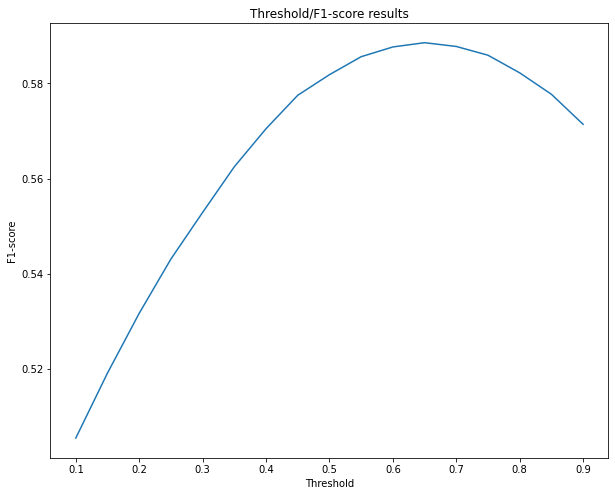

ROC-AUC score: 0.9050811364801654
Best threshold for F1-score: 0.6500000000000001
F1-score: 0.5885368023126529


              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1225312
           1       0.53      0.66      0.59     80810

    accuracy                           0.94   1306122
   macro avg       0.76      0.81      0.78   1306122
weighted avg       0.95      0.94      0.95   1306122



In [ ]:
print_result(df.target.values, preds)

# Часть 1.4 Объяснение предсказаний при помощи eli5

Используйте функционал eli5, чтобы посмотреть, как работает ваша модель, сделайте выводы. Для этого прочтите соответствующий туториал на странице https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html 

Тем, кто больше любит видосы, можно посмотреть выступление от одного из авторов библиотеки https://www.youtube.com/watch?v=9vYkwD0feb4

Спрашивать буду обязательно, так что разобраться придется.

In [ ]:
%pip install eli5

     |████████████████████████████████| 112kB 8.2MB/s 


In [ ]:
import eli5.formatters.as_dataframe as eli_df
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
model.fit(df.question_text, df.target)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                               class_weight={0: 0.06187017751787352,
                                             1: 0.9381298224821265},
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.1,
                       

### Вклад отдельных токенов

In [ ]:
eli_df.explain_weights_df(model, vec=vect, top=50, 
                            target_names=df.target)

,target,feature,weight
0,1,castrated,10.235521
1,1,castrate,9.270671
2,1,castration,9.088417
3,1,castrating,7.158599
4,1,rejuvalex,7.097304
5,1,horlaxen,6.858467
6,1,liberals,6.585434
7,1,idiots,6.367512
8,1,democrats,6.284043
9,1,drumpf,6.112847


### Принятие решения

In [ ]:
eli5.show_prediction(clf, df.question_text[400], vec=vect, target_names=df.target)

In [ ]:
eli_df.explain_prediction_df(clf, df.question_text[400], vec=vect, target_names=df.target)

,target,feature,weight,value
0,1,muslims,2.190084,0.374132
1,1,pope,1.019693,0.549302
2,1,curse,0.694337,0.540374
3,1,world,0.389207,0.302416
4,1,did,0.000635,0.252917
5,1,say,-0.066504,0.332965
6,1,<BIAS>,-2.658537,1.000000


In [ ]:
eli5.show_prediction(clf, df.question_text[100], vec=vect, target_names=df.target)

In [ ]:
eli_df.explain_prediction_df(clf, df.question_text[100], vec=vect, target_names=df.target)

,target,feature,weight,value
0,0,<BIAS>,2.658537,1.000000
1,0,think,0.434914,0.169190
2,0,philosophers,0.224768,0.343559
3,0,david,0.111240,0.295035
4,0,deutsch,0.085660,0.424021
5,0,theory,0.043746,0.248188
6,0,constructor,-0.012650,0.400270
7,0,computer,-0.143092,0.214532
8,0,physicists,-0.513382,0.344443
9,0,mathematicians,-0.625975,0.345122


Выше можно видеть, на основе чего модель приняла то или иное решение. Как правило, она очень уверена в тех ответах, где максимально много слов вносят позитивный или негативный оттенок в предложение.

# Часть 1.5 Стемминг и лемматизация

Проведите для текстов стемминг и лемматизацию. Поскольку это процесс не быстрый, лучше сохранить предобработанные тексты в отдельный столбец DataFrame. Обучите модель на стеммированных и лемматизированных данных, сравните размер словаря

In [ ]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer

In [ ]:
from functools import lru_cache

In [ ]:
# эта вспомогательная функция поможет вам чуть быстрее пройтись по всему тексту
# обратите внимание, что лемматизация будет в основном работать только для слов в нижнем регистре!

LEMMATIZER = WordNetLemmatizer()

@lru_cache(maxsize=2048)
def lemmatize_word(word):
    parts = ['a','v','n','r']
    for part in parts:
        temp = LEMMATIZER.lemmatize(word, part)
        if temp != word:
            return temp
    return word    

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:
print(lemmatize_word('having'))
print(stemmer.stem('having'))

have
have


In [ ]:
print(stemmer.stem('tolerant'))
print(stemmer.stem('tolerable'))

toler
toler


In [ ]:
tokenized = [sklearn_tokenizer(sent) for sent in df.question_text]

In [ ]:
def lemmatize_data(tokenized):
    for sent in tokenized:
        lemmatized_words_list = [lemmatize_word(word.lower()) for word in sent]

        yield ' '.join(lemmatized_words_list)

In [ ]:
def stemming_data(tokenized):
    for sent in tokenized:
        stem_words_list = [stemmer.stem(word.lower()) for word in sent]

        yield ' '.join(stem_words_list)

In [ ]:
lemmatized = list(lemmatize_data(tokenized))
stemmed = list(stemming_data(tokenized))

In [ ]:
df['lemmatized_text'] = lemmatized
df['stemmed_text'] = stemmed

In [ ]:
df.to_csv('train_mod.csv', index=False)

In [ ]:
df.loc[0:5, ['question_text', 'lemmatized_text', 'stemmed_text']].values

array([['How did Quebec nationalists see their province as a nation in the 1960s?',
        'how do quebec nationalist see their province a nation in the 1960s',
        'how did quebec nationalist see their provinc as nation in the 1960s'],
       ['Do you have an adopted dog, how would you encourage people to adopt and not shop?',
        'do you have an adopt dog how would you encourage people to adopt and not shop',
        'do you have an adopt dog how would you encourag peopl to adopt and not shop'],
       ['Why does velocity affect time? Does velocity affect space geometry?',
        'why do velocity affect time do velocity affect space geometry',
        'whi doe veloc affect time doe veloc affect space geometri'],
       ['How did Otto von Guericke used the Magdeburg hemispheres?',
        'how do otto von guericke use the magdeburg hemisphere',
        'how did otto von guerick use the magdeburg hemispher'],
       ['Can I convert montra helicon D to a mountain bike by just 

In [ ]:
vect_l = TfidfVectorizer(stop_words='english').fit(df.lemmatized_text)
vect_s = TfidfVectorizer(stop_words='english').fit(df.stemmed_text)

## Размеры словарей с леммингом и стеммингом

In [ ]:
len(vect_l.get_feature_names())

172041

In [ ]:
len(vect_s.get_feature_names())

153163

## Обучение (лемматизированные данные)

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1,
                    shuffle=True, n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})
model = Pipeline([('vect', vect), ('clf', clf)])

In [ ]:
%%time
preds = cross_val_predict(model, df.lemmatized_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

CPU times: user 3.96 s, sys: 325 ms, total: 4.29 s
Wall time: 2min 37s


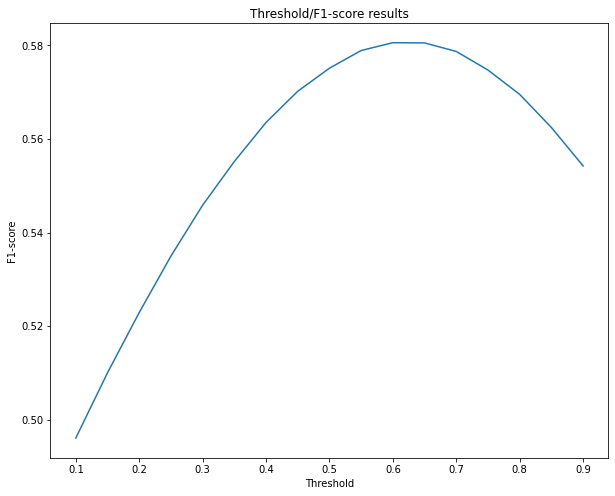

ROC-AUC score: 0.9049167245163279
Best threshold for F1-score: 0.6000000000000002
F1-score: 0.5805437103123685


              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1225312
           1       0.52      0.66      0.58     80810

    accuracy                           0.94   1306122
   macro avg       0.75      0.81      0.77   1306122
weighted avg       0.95      0.94      0.94   1306122



In [ ]:
print_result(df.target.values, preds)

## Обучение (стемминг)

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', alpha=1e-7, average=100, l1_ratio=0.1,
                    shuffle=True, n_jobs=-1, random_state=42, 
                    class_weight={0: true_class_weight, 1: 1-true_class_weight})
model = Pipeline([('vect', vect), ('clf', clf)])

In [ ]:
%%time
preds = cross_val_predict(model, df.stemmed_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

CPU times: user 3.87 s, sys: 293 ms, total: 4.16 s
Wall time: 2min 33s


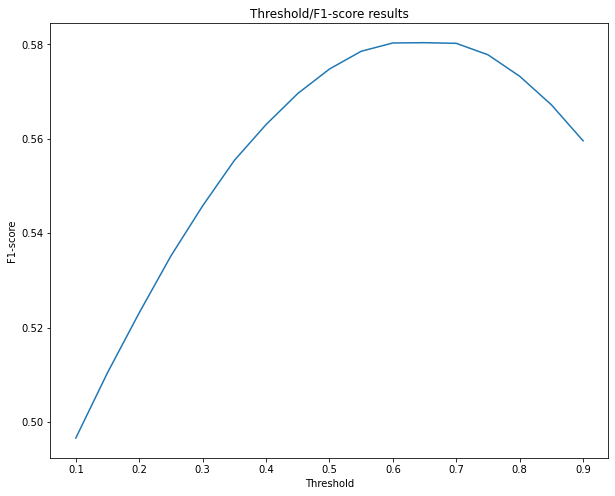

ROC-AUC score: 0.9045224715792435
Best threshold for F1-score: 0.6500000000000001
F1-score: 0.5803287306567343


              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1225312
           1       0.53      0.64      0.58     80810

    accuracy                           0.94   1306122
   macro avg       0.75      0.80      0.77   1306122
weighted avg       0.95      0.94      0.95   1306122



In [ ]:
print_result(df.target.values, preds)

# Часть 1.6 Оптимизация модели

Подберите с помощью GridSearch или RandomizedSearch хорошие параметры вашей модели. Когда вы делаете сетку для пайплайна параметры надо называть так как у внутреннего класса, добавляя названия соответствующего этапа перед ними. Например:

Попробуйте разные функции ошибок для SGD. Например hinge (внутри получится svm, нельзя будет предсказывать вероятности), modified_huber - комбинация l1 и l2 ошибки для классификации (упоминалась на одной из прошлых лекций). 
Разную предобработку, параметры, подберите порог принятия решения.

Попробуйте уменьшать размер словаря путем комбинации лемматизации (или стемминга) и увеличения min_df. Проанализируйте, как меняется размер словаря, а также качество модели.

In [ ]:
param_grid = {
    'clf__loss': ['modified_huber', 'hinge'],
    'vect__min_df': [25, 50],
    'vect__vocabulary': [vect_l.get_feature_names(), vect_s.get_feature_names()]
}

In [ ]:
vect = TfidfVectorizer(stop_words='english', lowercase=True)
clf = SGDClassifier(penalty='elasticnet', shuffle=True, n_jobs=-1, random_state=42, l1_ratio=0.1, alpha=1e-7,
                    class_weight={0: true_class_weight, 1: 1-true_class_weight}, average=10)
model = Pipeline([('vect', vect), ('clf', clf)])

estimator = RandomizedSearchCV(model, param_grid, scoring=thres_f1_score, n_jobs=-1, n_iter=5,
                               cv=StratifiedKFold(5), random_state=42, verbose=1)

In [ ]:
%%time
estimator.fit(df.question_text.values, df.target.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 13.2min finished


CPU times: user 1min 48s, sys: 3.08 s, total: 1min 51s
Wall time: 14min 7s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                 

In [ ]:
estimator.best_params_['vect__vocabulary'] == vect_l.get_feature_names()

True

In [ ]:
vect = TfidfVectorizer(stop_words='english', lowercase=True, min_df=25, vocabulary=vect_l.get_feature_names())
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', shuffle=True, n_jobs=-1, random_state=42, l1_ratio=0.1, alpha=1e-7,
                    class_weight={0: true_class_weight, 1: 1-true_class_weight}, average=10)
model = Pipeline([('vect', vect), ('clf', clf)])

In [ ]:
preds = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1, 
                          method='predict_proba')[:, 1]

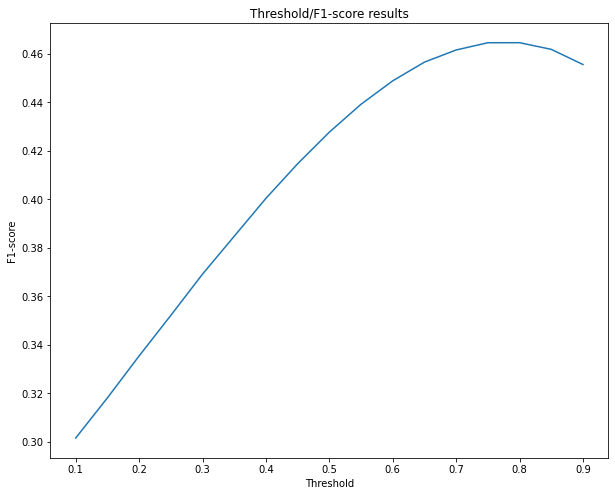

ROC-AUC score: 0.8674427126898208
Best threshold for F1-score: 0.8000000000000002
F1-score: 0.4646733716965775


              precision    recall  f1-score   support

           0       0.97      0.96      0.96   1225312
           1       0.43      0.51      0.46     80810

    accuracy                           0.93   1306122
   macro avg       0.70      0.73      0.71   1306122
weighted avg       0.93      0.93      0.93   1306122



In [ ]:
print_result(df.target.values, preds)

# Часть 2 (На 10). Тематическое моделирование

Используйте либо https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html, либо модели из gensim для тематического моделирования на этих текстах. Посмотрите на полученные темы, попытайтесь их интерпретировать. Используйте распределение тем для документа в качестве набора признаков, описывающих его. Обучите модель на этих признаках и сравните с tf-idf.

Поскольку задание на 10 тут не будет никакой дополнительной информацию. Те, кто делают, пусть пишут мне сообщения и задают вопросы на паре. Отвечу и помогу точечно.

In [ ]:
import gensim.corpora
from gensim.models import LdaMulticore

In [ ]:
def lemmatize_data(tokenized):
    for sent in tokenized:
        lemmatized_words_list = [lemmatize_word(word.lower()) for word in sent
                                if word.lower() not in stopwords.words('english')]

    yield lemmatized_words_list

In [ ]:
processed_docs = list(lemmatize_data(tokenized[:500]))

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
processed_docs[1], bow_corpus[1]

(['adopt', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'],
 [(6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)])

In [ ]:
model = LdaMulticore(bow_corpus, num_topics=10, passes=10, id2word=dictionary, workers=4, random_state=42)

In [ ]:
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

Topic: 0 
Words: 0.010*"like" + 0.009*"way" + 0.009*"best" + 0.007*"start" + 0.007*"change" + 0.005*"happen" + 0.005*"iphone" + 0.005*"go" + 0.005*"make" + 0.005*"good"

Topic: 1 
Words: 0.017*"know" + 0.013*"get" + 0.008*"feel" + 0.008*"time" + 0.006*"ask" + 0.006*"need" + 0.006*"become" + 0.006*"space" + 0.006*"native" + 0.004*"someone"

Topic: 2 
Words: 0.010*"use" + 0.010*"think" + 0.010*"best" + 0.008*"way" + 0.008*"good" + 0.008*"happen" + 0.007*"create" + 0.007*"like" + 0.007*"go" + 0.006*"get"

Topic: 3 
Words: 0.015*"good" + 0.015*"use" + 0.010*"one" + 0.008*"book" + 0.008*"give" + 0.006*"best" + 0.006*"mean" + 0.006*"ever" + 0.006*"time" + 0.006*"buy"

Topic: 4 
Words: 0.009*"time" + 0.007*"people" + 0.007*"power" + 0.007*"come" + 0.007*"question" + 0.007*"india" + 0.005*"place" + 0.005*"want" + 0.005*"business" + 0.005*"see"

Topic: 5 
Words: 0.009*"muslim" + 0.008*"get" + 0.007*"woman" + 0.007*"make" + 0.007*"basic" + 0.007*"start" + 0.007*"marry" + 0.007*"good" + 0.007*"fa

# Часть 3. word2vec

В этой части вам надо будет пощупать вектора слов, поискать ассоциации, а потом использовать эти вектора как признаки для вашей модели.


Скачайте векторы отсюда и загрузите их при помощи кода ниже.

https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download


Если ваш компьютер не позволяет загрузить большие векторы, воспользуйтесь векторами вот отсюда. Они будут в 10 раз меньше по размеру.

https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz

Для работы с большими векторами нужно как минимум 8 гб оперативной памяти. Если у вас их нет, то пользуйтесь маленькими, либо google colaboratory, либо kaggle kernels.

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', binary=True)

# Задание 3.1 Знакомство с векторами

Пощупайте векторы и найдите по крайней мере 2 **семантических** и 2 **синтаксических** аналогии

In [ ]:
# вот так можно получить вектор слова
w2v['Minsk']

array([ 2.46019829e-02,  5.92508493e-03,  5.04920259e-02,  1.43232480e-01,
        3.37472223e-02, -1.09485257e-02,  1.61007736e-02, -2.00454635e-03,
       -1.22108266e-01, -3.88028636e-03, -5.35833761e-02,  8.03750604e-02,
        8.56561121e-03,  3.99299189e-02,  2.08666027e-02,  1.30094253e-02,
       -6.38878718e-02, -1.31382318e-02, -2.52460130e-02, -4.55973931e-02,
        7.57380426e-02, -6.31150305e-02,  3.86418565e-03, -1.24297971e-02,
        3.47776711e-02, -1.06667627e-04, -6.85248896e-02, -1.90633163e-02,
       -8.81034359e-02,  2.02225726e-02, -9.01643336e-02, -3.73537950e-02,
       -4.04451452e-02,  2.17682458e-02,  4.45669405e-02,  2.27986965e-02,
       -9.06795561e-02,  5.79627864e-02, -2.03674799e-03, -9.22252312e-02,
        3.25879678e-02,  9.91807692e-03,  8.14055130e-02, -3.23303528e-02,
       -4.66922444e-04, -1.31382318e-02,  9.01643373e-03, -1.25586037e-02,
       -4.40517180e-02,  5.87356240e-02, -6.44030934e-03, -1.32026349e-03,
        8.45133400e-07,  

Вот так работают аналогии

In [ ]:
# vec(Minsk) - vec(Belarus) + vec(Russia) ~= vec(Moscow)
w2v.most_similar(positive=['Minsk', 'Russia'], negative=['Belarus'])

[('Moscow', 0.790582537651062),
 ('Tbilisi', 0.6598106622695923),
 ('Kyiv', 0.65132737159729),
 ('Kremlin', 0.6477817296981812),
 ('Kiev', 0.6403968930244446),
 ('Baku', 0.6180801391601562),
 ('Vilnius', 0.6057641506195068),
 ('Putin', 0.5993436574935913),
 ('Russian', 0.5992746353149414),
 ('Irkutsk', 0.591408371925354)]

## Семантические

In [ ]:
w2v.most_similar(positive=['Queen', 'Man'], negative=['Woman'])

[('King', 0.5305259227752686),
 ('Royal', 0.42858511209487915),
 ('Princes', 0.4225396513938904),
 ('Princess', 0.40732985734939575),
 ('Scu', 0.39969244599342346),
 ('king', 0.396353542804718),
 ('Crown', 0.39470231533050537),
 ('Empress', 0.387243390083313),
 ('Conqueror', 0.38679999113082886),
 ('queen', 0.38513821363449097)]

In [ ]:
w2v.most_similar(positive=['Dress', 'Man'], negative=['Woman'])

[('Shirt', 0.47823381423950195),
 ('Shirts', 0.4741184711456299),
 ('Sweatpants', 0.47068238258361816),
 ('Pants', 0.45401132106781006),
 ('Shoes', 0.45261988043785095),
 ('Wear', 0.4474624991416931),
 ('dress', 0.4428718686103821),
 ('Jeans', 0.4369615912437439),
 ('Scarf', 0.43385377526283264),
 ('Wellies', 0.4296019375324249)]

## Синтаксические

In [ ]:
w2v.most_similar(positive=['going', 'ride'], negative=['go'])

[('riding', 0.6325759887695312),
 ('rides', 0.5956701040267944),
 ('rode', 0.490901917219162),
 ('Ride', 0.4376450181007385),
 ('riders', 0.4254390597343445),
 ('Rides', 0.42220520973205566),
 ('gonna', 0.4209027886390686),
 ('pedaling', 0.4135042130947113),
 ('rollercoaster', 0.412050724029541),
 ('unridable', 0.4117525815963745)]

In [ ]:
w2v.most_similar(positive=['his', 'she'], negative=['he'])

[('her', 0.9412580132484436),
 ('Her', 0.7321809530258179),
 ('herself', 0.6434346437454224),
 ('hers', 0.6302345395088196),
 ('my', 0.5611376166343689),
 ('She', 0.5026185512542725),
 ('His', 0.497707724571228),
 ('momager', 0.46197617053985596),
 ('My', 0.45305511355400085),
 ('motherhood', 0.45073992013931274)]

# Задание 3.2 Использование среднего вектора в качестве фичей для моделирования

Как мы и говорили на лекции, вектора слов можно использовать для построения признакового описания текста путем усреднения векторов. Сделайте это. Для этого нужно:
1. Токенизировать каждый текст
2. Для каждого токена попробовать найти вектор в w2v. Если его там нет, то просто игнорировать.
3. Усреднить все вектора слов текста для получения его признакового описания. Если ни одного из слов в тексте нет вектора, то вернуть вектор из нулей той же длины

На полученных признаках обучите модель для предсказания и сравните качество.

ВНИМАНИЕ! Не забывайте нормировать вектора с помощью numpy!



In [ ]:
def get_w2v_vect(token, w2v):
    token = token.lower()

    if token in w2v.index2word:
        return w2v[token]
    else:
        return np.zeros(w2v.vector_size) 

In [ ]:
def get_features_from_text(tokenized_sent, w2v):
    vect = np.array([get_w2v_vect(token, w2v) 
                    for token in tokenized_sent]).mean(axis=0)
  
    vect_norm = np.linalg.norm(vect)
    if vect_norm != 0:
        return vect/vect_norm
    else:
        return vect

In [ ]:
w2v_data = np.array([get_features_from_text(tokenized_sent, w2v) 
                    for tokenized_sent in tokenized[::5]])
#w2v_data = np.load('w2v_data.npy')

In [ ]:
y = df.target[::5]

In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.1, alpha=1e-6, 
                    shuffle=True, class_weight={0: y.mean(), 1: 1-y.mean()}, random_state=42)

In [ ]:
preds = cross_val_predict(clf, w2v_data, y, cv=StratifiedKFold(5), 
                          n_jobs=-1, method='predict_proba')[:, 1]

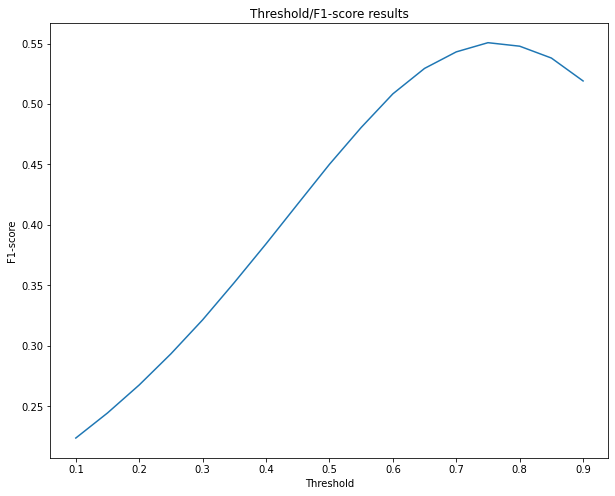

ROC-AUC score: 0.931747925316993
Best threshold for F1-score: 0.7500000000000002
F1-score: 0.5506838608831575


              precision    recall  f1-score   support

           0       0.98      0.95      0.96    244966
           1       0.48      0.65      0.55     16259

    accuracy                           0.93    261225
   macro avg       0.73      0.80      0.76    261225
weighted avg       0.95      0.93      0.94    261225



In [ ]:
print_result(y, preds)

На признаках текстов, полученных из word2vec не получилось особо повысить качество классификации.

# Задание 3.3 (На 9) Рисуем вектора вопросов с помощью t-SNE

Вам необходимо использовать векторизацию текстов с помощью word2vec и алгоритм t-sne из прошлой лабы, чтобы нарисовать в двумерном пространстве вопросы и попытаться посмотреть, нет ли в них каких-то групп.


In [ ]:
%pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=7b9eebfa231fe3968673a2e6be885e43f4e5cfb3a92275d7c97988ddd1e69dbd
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [ ]:
from MulticoreTSNE import MulticoreTSNE

In [ ]:
tsne = MulticoreTSNE(perplexity=5, learning_rate=100, n_jobs=4, 
                     random_state=42)
embeddings = tsne.fit_transform(w2v_data[:1000])
vis_x, vis_y = embeddings[:, 0], embeddings[:, 1]

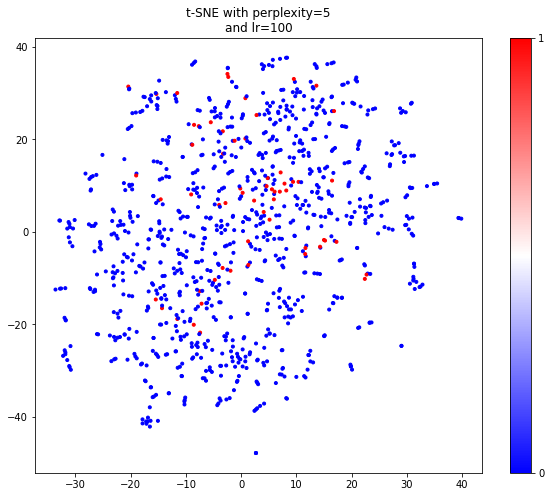

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('t-SNE with perplexity=5\nand lr=100')
plt.scatter(vis_x, vis_y, c=y[:1000], 
            cmap='bwr', marker='.')
plt.colorbar(ticks=[0, 1])
plt.clim(0, 1)
plt.show()

# Задание 3.4 (На +1 к лабораторной по кластеризации). Кластеризация текстов на основе векторизации

Возьмите какую-то из векторизаций текстов на выбор и проведите для них кластеризацию способами из прошлой лабы по всем правилам. Попробуйте объяснить найденные кластеры и представить результат преподавателю. 

P.S. Если у вас и так 10 за кластеризацию, то плюс можно будет добавить к любой лабе. Если у вас 10 за все лабы, то я вами горжусь!

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score
import matplotlib.cm as cm

In [ ]:
def hopkins_statistic(X, m_fraction=1):
    d = X.shape[1]
    n = X.shape[0]
    m = int(m_fraction * n)
    X_scaled = StandardScaler().fit_transform(X)
    X_sample = X_scaled[np.random.choice(range(0, n), m, replace=False)]
    neighbors = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(X_scaled)
    Y_rand = np.random.uniform(-1, 1, size=(m, d))
    y = []
    x = []
    for j in range(0, m):
        y.append(neighbors.kneighbors(Y_rand[j].reshape(1, -1),
                                      n_neighbors=1,
                                      return_distance=True)[0][0][0])
        x.append(neighbors.kneighbors(X_sample[j].reshape(1, -1),
                                      n_neighbors=2,
                                      return_distance=True)[0][0][1])

    H = sum(y) / (sum(x) + sum(y))
    return 1 - H

In [ ]:
def plot_silhouette(X, n_clusters, y_true=None):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = clusterer.fit_predict(X)

    sample_silhouette_values = silhouette_samples(X, y_pred)
    silhouette_avg = np.mean(sample_silhouette_values)

    print('For n_clusters =', n_clusters,
        '\nThe average silhouette_score is', silhouette_avg)
        
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    if y_true is not None:
        ax1.set_title(f'The silhouette plot for {n_clusters} clusters.' + 
            f'\n Homogeneity index for MNIST ({n_clusters} clusters): ' +
             f'{round(homogeneity_score(y_true, y_pred), 4)}')
    else:
        ax1.set_title(f'The silhouette plot for {n_clusters} clusters.')

    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')

    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c='white', alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title('The visualization of the clustered data.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')

    plt.suptitle(('Silhouette analysis for KMeans clustering on sample data '
                  'with n_clusters = %d' % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [ ]:
print(f'Hopkins statistic for original w2v: {hopkins_statistic(w2v_data[:1000])}')
print(f'Hopkins statistic for t-SNE: {hopkins_statistic(embeddings[:1000])}')

Hopkins statistic for original w2v: 0.5437515674713282
Hopkins statistic for t-SNE: 0.37787382881724185


## Кластеризация для векторизованных текстов

For n_clusters = 2 
The average silhouette_score is 0.05470155573084483


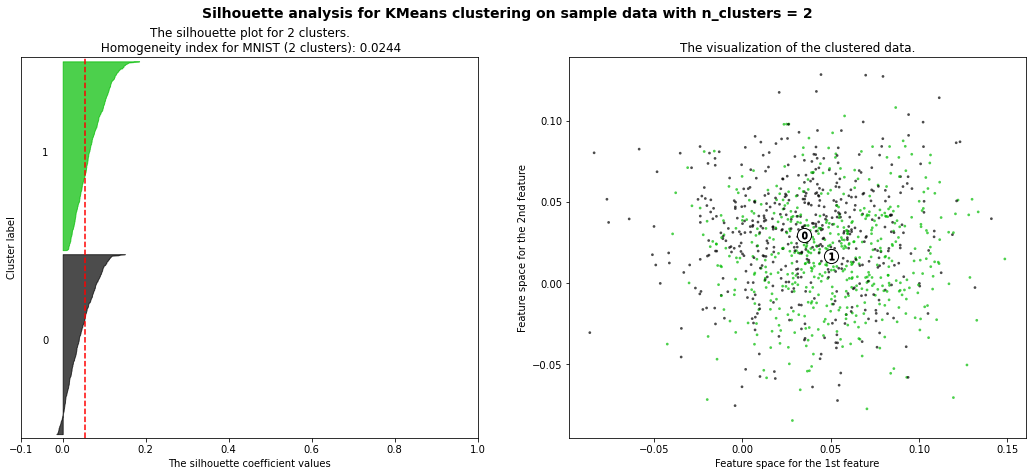

In [ ]:
plot_silhouette(w2v_data[:1000], 2, y[:1000])

For n_clusters = 2 
The average silhouette_score is 0.42349125652217134


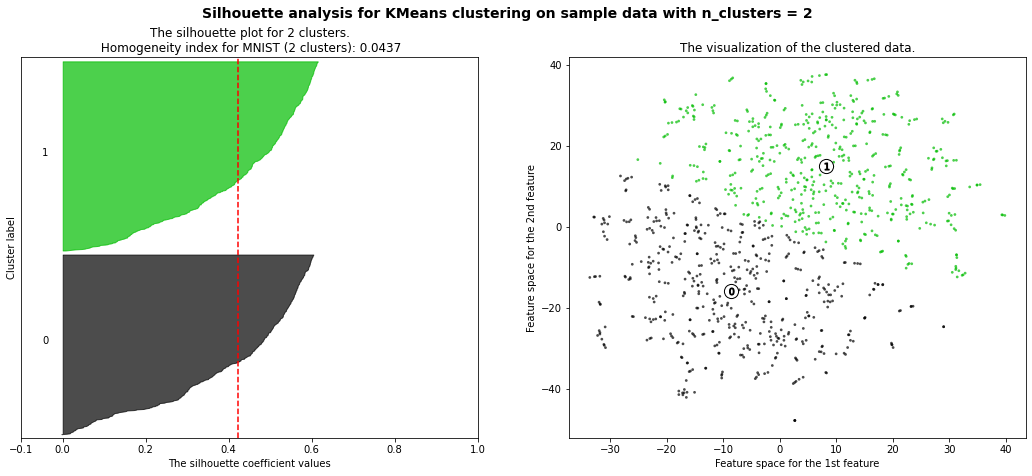

In [ ]:
plot_silhouette(embeddings, 2, y[:1000])

Как можно заметить, в данных нет ярковыраженной кластерной структуры. После применения t-SNE понижения размерности кластерная структура слегка улучшилась, но по индексу гомогенности можно сделать вывод, что кластеризация тут весьма неэффективная для соответствующих меток класса.

# Часть 4. Давайте используем Transformers как полностью черный ящик и сравним качество 

Давайте теперь попробуем взять вектора слов из другого источника. В этом нам поможет библиотека sentence_transformers, которую вам нужно установить следующим образом:
1. conda install -c conda-forge sentence-transformers
2. Если при загрузке модели у вас вываливаются ошибки, в которых что-то говорится о несовместимых версиях файлов, то убедитесь, что вас установился pytorch версии 1.6 или выше с помощью conda list. Обновите, если вдруг это не так.

In [ ]:
%pip install sentence-transformers

     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 2.3MB 39.1MB/s 
     |████████████████████████████████| 1.2MB 49.5MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 
     |████████████████████████████████| 901kB 55.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=672b4fd0b2a50119b698982fad9fda930570a53d130c20293e4bccd74164f21f
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

В качестве векторизатора возьмем модель, которую авторы библиотеки рекомендуют по умолчанию. Во время первого выполнения ячейки файл с весами модели будет скачан вам на компьютер.

В дальнейшем используйте model.encode, чтобы преобразовать ваши тексты в вектора. Обратите внимание, что токенизация происходит внутри. Если будет ошибка, связанная с logger, то установите параметр show_progress_bar=False.

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1', device='cuda')

Преобразуйте все тексты в признаки (их должно быть 768 для каждого текста). Обучите SGDClassifer на этих признаках и сравните качество с предыдущими вариантами.

In [ ]:
%%time
pool = model.start_multi_process_pool(target_devices=['cuda', 'cuda'])
embedding = model.encode_multi_process(df.question_text.values[::5], pool)

print("Embeddings computed. Shape:", embedding.shape)
model.stop_multi_process_pool(pool)

Embeddings computed. Shape: (261225, 768)
CPU times: user 1.57 s, sys: 1.17 s, total: 2.74 s
Wall time: 3min 37s


In [ ]:
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet', l1_ratio=0.1, alpha=1e-6, 
                    shuffle=True, class_weight={0: y.mean(), 1: 1-y.mean()}, random_state=42)

In [ ]:
%%time
preds = cross_val_predict(clf, embedding, y, cv=StratifiedKFold(5), 
                          n_jobs=-1, method='predict_proba')[:, 1]

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 2.8 s, sys: 723 ms, total: 3.52 s
Wall time: 12min 34s


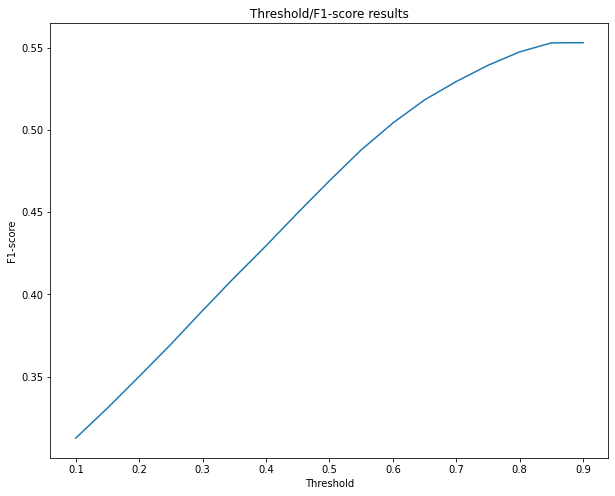

ROC-AUC score: 0.926739073849324
Best threshold for F1-score: 0.9000000000000002
F1-score: 0.5529476584022038


              precision    recall  f1-score   support

           0       0.97      0.96      0.97    244966
           1       0.50      0.62      0.55     16259

    accuracy                           0.94    261225
   macro avg       0.74      0.79      0.76    261225
weighted avg       0.94      0.94      0.94    261225



In [ ]:
print_result(y, preds)